# Field layout discretization

This notebook demonstrates how to uniformly discretize the field layout parameters.

Import necessary packages:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# The following libraries are not standard and have to be installed separately.
# It is recommended to install shapely using conda.
import pvlib
from shapely import geometry

## Define collector aperture area

First, it is necessary to define the collector aperture, as this determines the feasible range of ground cover ratios and aspect ratios. 

This example will be based on a square collector aperture, as defined below (other geometries are easily defined using shapely):

Collector area: 1.0
Collector L_min: 1.41


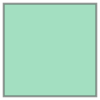

In [2]:
# Definition of aperture geometry using shapely
collector_geometry = geometry.box(-0.5, -0.5, 0.5, 0.5)
collector_area = collector_geometry.area

# Calculate the minimum distance between trackers (L_min) - also called D_min
L_min = 2*collector_geometry.hausdorff_distance(geometry.Point(0, 0))

print("Collector area: %2.1f"% collector_area)
print("Collector L_min: %1.2f"% L_min)
collector_geometry

## Determine discrete simulation layouts
The second step is to define the discrete GCRs to simulate and the step size for the discretization of the aspect ratios, offsets, and rotations.

The discretization assumes that the parameters are simulated for the entire range, i.e., aspect ratios: [0.866, GCR<sub> max</sub> ], rotations: [0, 180), and offsets: [-0.5, 0.5].

In [3]:
# Determine range of gcrs
gcr_step = 0.05
gcr_start = 0.1
# The maximum GCR depends on the collector aperture geometry
gcr_max = collector_area / (L_min**2 * np.sqrt(1-(-0.5)**2))
gcrs = np.round(np.hstack([np.arange(gcr_start, gcr_max, gcr_step), gcr_max]), 3)

# Determine step size for discretization of the aspect ratio, offset, and rotation
aspect_ratio_step = 0.05
offset_step = 0.05
rotation_step = 5

# Calculate discrete rotations and offsets
rotations = np.arange(0, 180, rotation_step)
offsets = np.arange(-0.5, 0.5+offset_step, offset_step)

<br>

Generate a dataframe of unique feasible discrete layouts:

In [4]:
parameters = []
for gcr in gcrs:
    for offset in offsets:
        for rotation in rotations:
            aspect_ratio_max = collector_area/(gcr*L_min**2)
            aspect_ratio_min = np.sqrt(1-offset**2)
            aspect_ratio_start = np.ceil(aspect_ratio_min/aspect_ratio_step)*aspect_ratio_step
            aspect_ratios = np.hstack(
                [aspect_ratio_min,
                 np.arange(aspect_ratio_start, aspect_ratio_max, aspect_ratio_step),
                 aspect_ratio_max
                 ])
            # Remove duplicate values when aspect_ratio_min==1
            aspect_ratios = np.unique(aspect_ratios)
            for aspect_ratio in aspect_ratios:
                if gcr <= collector_area / (L_min**2 * np.sqrt(1-offset**2)):
                    parameters.append([gcr, aspect_ratio, offset, rotation])

layouts = pd.DataFrame(parameters,
                       columns=['gcr', 'aspect_ratio', 'offset', 'rotation'])

print(f"Number of unique layouts: {layouts.shape[0]}")
layouts.head()

Number of unique layouts: 174960


,gcr,aspect_ratio,offset,rotation
0,0.1,0.866025,-0.5,0
1,0.1,0.900000,-0.5,0
2,0.1,0.950000,-0.5,0
3,0.1,1.000000,-0.5,0
4,0.1,1.050000,-0.5,0


## Visualization of layout discretization
The following plot illustrates the discrete aspect ratios and offsets for GCR=0.2 and GCR=0.3. Note, each point shown is simulated for the all discrete rotations.

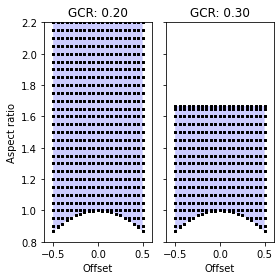

In [5]:
gcrs_subset = np.array([0.2, 0.3])

fig, axes = plt.subplots(ncols=len(gcrs_subset), figsize=(4,4), sharey=True)
axes[0].set_yticks(np.arange(0.8, 10, 0.2))

for i, gcr in enumerate(gcrs_subset):
    layouts[(layouts['gcr'] == gcr)].plot.scatter( #  & (layouts['offset']<0.5-0.00001)
        ax=axes[i], x='offset', y='aspect_ratio', s=1, c='k',
        legend=False, zorder=2)

    axes[i].set_xlabel('Offset')
    axes[i].set_title("GCR: %1.2f" % gcr)
    axes[i].set_xticks([-0.5, 0, 0.5])
    axes[i].set_xlim([-0.6, 0.6])
    axes[i].set_ylim([0.8, 2.2])
    axes[i].tick_params(axis='both', which='major')
    x_vals = np.linspace(-0.5, 0.5, 100)
    aspect_ratio_max = collector_area/(gcr*L_min**2)
    axes[i].fill_between(x_vals, np.sqrt(1-x_vals**2), aspect_ratio_max, facecolor='b', alpha=0.2)
axes[0].set_ylabel('Aspect ratio')

fig.tight_layout()